In [1]:
# Cài đặt và Cấu hình Môi trường
!pip install -q pyvi sklearn-crfsuite
!pip install -q evaluate seqeval
!pip install -q transformers datasets accelerate
!pip install -q protobuf==3.20.3
!pip install -q torch
!apt-get install -q -y fonts-noto-core

Reading package lists...
Building dependency tree...
Reading state information...
fonts-noto-core is already the newest version (20201225-1build1).
0 upgraded, 0 newly installed, 0 to remove and 165 not upgraded.


In [2]:
import os
import random
import json
import logging
import warnings
import shutil
import numpy as np
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm
import matplotlib.font_manager as fm
from collections import Counter
import joblib

from pyvi import ViTokenizer
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn_crfsuite import CRF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn_crfsuite.metrics import flat_f1_score, flat_classification_report
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from transformers import AutoTokenizer, AutoModel
from transformers import pipeline

2025-12-22 19:16:40.835210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766431000.856883     267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766431000.863803     267 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Cấu hình Font cho Matplotlib
system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = next((f for f in system_fonts if 'NotoSans-Regular.ttf' in f), None)
font_prop = fm.FontProperties(fname=font_path) if font_path else None
plt.style.use('seaborn-v0_8-whitegrid')

# CẤU HÌNH IGNORE VÀ SEED
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Đã cài đặt và cấu hình môi trường thành công!")

# CẤU HÌNH NHÃN CHUẨN
label_list = [
    "O",
    "B-LOC", "I-LOC",
    "B-VEH", "I-VEH",
    "B-EVENT", "I-EVENT",
    "B-PER_DRIVER", "I-PER_DRIVER",
    "B-PER_VICTIM", "I-PER_VICTIM",
    "B-ORG", "I-ORG",
    "B-CONSEQUENCE", "I-CONSEQUENCE",
    "B-TIME", "I-TIME",
    "B-CAUSE", "I-CAUSE"
]

label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}

print(f"Tổng số nhãn: {len(label_list)}")

Đã cài đặt và cấu hình môi trường thành công!
Tổng số nhãn: 19


# --- LOAD DATA ---

In [4]:
def convert_data_label_studio_to_bio(json_path):
    print(f"Đang đọc file: {json_path}")
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    processed_data = []
    
    label_counts = {label: 0 for label in label_list} 

    # Danh sách nhãn mục tiêu chuẩn (để lọc rác)
    valid_entities = [
        "LOC", "VEH", "EVENT", "PER_DRIVER", "PER_VICTIM", 
        "ORG", "CONSEQUENCE", "TIME", "CAUSE"
    ]

    for item in data:
        # Lấy text gốc
        if 'data' in item:
            raw_text = item['data']['text']
        else:
            continue

        words = raw_text.split() 
        
        # Mặc định gán tất cả là "O"
        labels = ["O"] * len(words)
        
        # Map vị trí từ
        word_spans = [] 
        current_char = 0
        for w in words:
            start = raw_text.find(w, current_char)
            end = start + len(w)
            word_spans.append((start, end))
            current_char = end
        
        if 'annotations' in item:
            for annotation in item['annotations']:
                for result in annotation['result']:
                    if result['type'] == 'labels':
                        label_type = result['value']['labels'][0]
                        
                        # LỌC NHÃN "O"
                        if label_type == "O":
                            continue

                        # Chuẩn hóa tên nhãn
                        if label_type == "Cause": label_type = "CAUSE" 
                        if label_type == "CAUSES": label_type = "CAUSE"
                        
                        if label_type not in valid_entities:
                            continue

                        start_char = result['value']['start']
                        end_char = result['value']['end']
                        
                        start_token_idx = -1
                        end_token_idx = -1
                        
                        # Tìm token tương ứng
                        for idx, (w_start, w_end) in enumerate(word_spans):
                            if max(w_start, start_char) < min(w_end, end_char):
                                if start_token_idx == -1: start_token_idx = idx
                                end_token_idx = idx
                        
                        # Gán BIO
                        if start_token_idx != -1:
                            b_label = f"B-{label_type}"
                            i_label = f"I-{label_type}"
                            
                            if b_label in label_list:
                                labels[start_token_idx] = b_label
                                label_counts[b_label] += 1
                                if end_token_idx > start_token_idx:
                                    for k in range(start_token_idx + 1, end_token_idx + 1):
                                        labels[k] = i_label

        if len(words) > 0:
            processed_data.append({
                "id": str(item['id']),
                "tokens": words,
                "ner_tags_str": labels # Lưu tạm labels dạng chuỗi để xử lý sau
            })

    # TÁCH TỪ BẰNG PYVI VÀ GỘP NHÃN 
    print("Đang thực hiện tách từ (PyVi) và cập nhật nhãn cho NER...")
    final_data = []
    
    for entry in processed_data:
        old_tokens = entry['tokens']
        old_labels = entry['ner_tags_str']
        
        #ViTokenizer
        text = " ".join(old_tokens)
        tokenized_text = ViTokenizer.tokenize(text)
        new_tokens = tokenized_text.split()
        
        new_labels = []
        idx = 0 
        
        for token in new_tokens:
            # Lấy nhãn của từ đơn đầu tiên trong cụm từ ghép
            # Ví dụ: "Hà_Nội" (token mới) được gộp từ "Hà" (idx) và "Nội" (idx+1)
            # Chúng ta lấy nhãn của "Hà" (ví dụ B-LOC) gán cho "Hà_Nội"
            if idx < len(old_labels):
                current_label = old_labels[idx]
                new_labels.append(current_label)
            else:
                new_labels.append("O")
            
            # Di chuyển con trỏ idx: 
            # Đếm số lượng dấu gạch dưới để biết token mới bao gồm bao nhiêu token cũ
            # Ví dụ: "Hà_Nội" có 1 dấu _, nghĩa là gồm 2 từ đơn -> tăng idx thêm 2
            sub_word_count = token.count("_") + 1
            idx += sub_word_count
            
        entry['tokens'] = new_tokens
        entry['ner_tags_str'] = new_labels
        entry['ner_tags'] = [label2id.get(l, 0) for l in new_labels]
        
        final_data.append(entry)
    
    return final_data


json_path = '/kaggle/input/vietnamese-traffic-accident-ner-dataset/output.json' 
raw_data = convert_data_label_studio_to_bio(json_path)

train_data, temp_data = train_test_split(raw_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.77, random_state=42)

print(f"Tổng số câu: {len(raw_data)}")
print(f" - Train set (70%): {len(train_data)} câu")
print(f" - Val set   (10%): {len(val_data)} câu")
print(f" - Test set  (20%): {len(test_data)} câu")

Đang đọc file: /kaggle/input/vietnamese-traffic-accident-ner-dataset/output.json
Đang thực hiện tách từ (PyVi) và cập nhật nhãn cho NER...
Tổng số câu: 1651
 - Train set (70%): 1155 câu
 - Val set   (10%): 114 câu
 - Test set  (20%): 382 câu


In [5]:
# Load PhoBERT base & Tokenizer
model_checkpoint = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
base_model = AutoModel.from_pretrained(model_checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

def extract_features(dataset):
    print("Đang trích xuất đặc trưng (Vector hóa)...")
    
    X_flat = [] 
    y_flat = []
    X_seq = []
    y_seq = []

    for item in tqdm(dataset):
        tokens = item['tokens']
        ner_tags = item['ner_tags']
        ner_strs = item['ner_tags_str']
        
        # Tokenize (xử lý từng câu một)
        inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
        
        with torch.no_grad():
            outputs = base_model(**inputs)
        
        embeddings = outputs.last_hidden_state[0].cpu().numpy() # [seq_len, 768]
        
        try:
            word_ids = inputs.word_ids()
        except ValueError:
            word_ids = [None]
            for i, word in enumerate(tokens):
                # Tokenize riêng từng từ để biết nó tách ra bao nhiêu subword
                sub_tokens = tokenizer.encode(word, add_special_tokens=False)
                # Gán index từ gốc cho tất cả subword của nó
                word_ids.extend([i] * len(sub_tokens))
            
            word_ids.append(None)
            
            # Cắt bớt nếu bị truncate (để khớp độ dài với input_ids)
            input_len = inputs['input_ids'].shape[1]
            if len(word_ids) > input_len:
                word_ids = word_ids[:input_len]
        
        sent_feats = []
        sent_labels = []
        seen_word_idx = set()
        
        for idx, word_id in enumerate(word_ids):
            if word_id is None: continue 
            
            if word_id >= len(ner_tags): continue

            if word_id not in seen_word_idx:
                vec = embeddings[idx]
                label_id = ner_tags[word_id]
                label_str = ner_strs[word_id]
                
                X_flat.append(vec)
                y_flat.append(label_id)
                
                feat_dict = {f'd{i}': v for i, v in enumerate(vec)}
                sent_feats.append(feat_dict)
                sent_labels.append(label_str)
                
                seen_word_idx.add(word_id)
        
        if len(sent_feats) > 0:
            X_seq.append(sent_feats)
            y_seq.append(sent_labels)

    return np.array(X_flat), np.array(y_flat), X_seq, y_seq

# Thực hiện trích xuất
print("--> Xử lý tập Train:")
X_train_ml, y_train_ml, X_train_crf, y_train_crf = extract_features(train_data)

print("--> Xử lý tập Test:")
X_test_ml, y_test_ml, X_test_crf, y_test_crf = extract_features(test_data)

print(f"Hoàn thành! Kích thước tập Train (Vectors): {X_train_ml.shape}")

--> Xử lý tập Train:
Đang trích xuất đặc trưng (Vector hóa)...


  0%|          | 0/1155 [00:00<?, ?it/s]

--> Xử lý tập Test:
Đang trích xuất đặc trưng (Vector hóa)...


  0%|          | 0/382 [00:00<?, ?it/s]

Hoàn thành! Kích thước tập Train (Vectors): (80717, 768)


Đang thống kê dữ liệu...


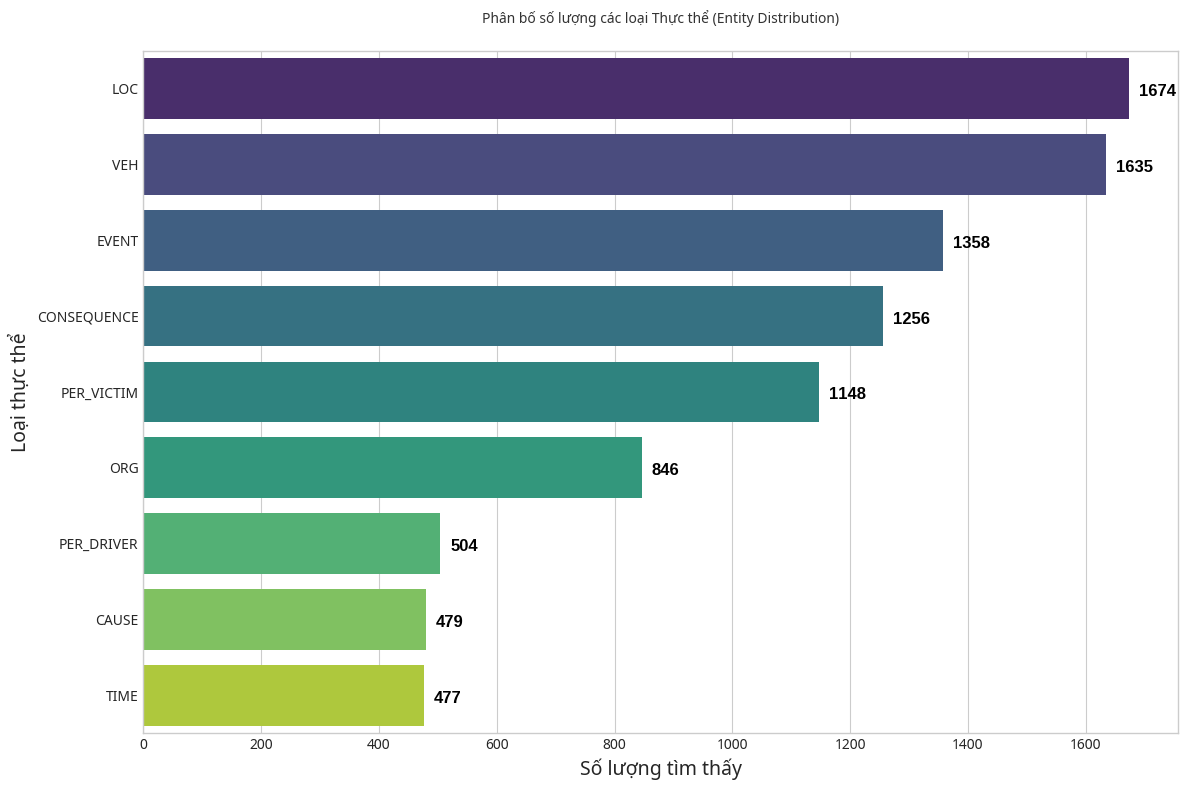

In [6]:
def plot_entity_distribution(dataset, id2label):
    clean_labels = []
    print("Đang thống kê dữ liệu...")
    for item in dataset:
        tags = [id2label[i] for i in item['ner_tags']] 
        for tag in tags:
            if tag.startswith("B-"):
                clean_labels.append(tag[2:]) 

    # Đếm số lượng
    label_counts = Counter(clean_labels)
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    labels, counts = zip(*sorted_labels)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(labels), palette="viridis")
    
    title_font = font_prop if font_prop else None
    
    plt.title('Phân bố số lượng các loại Thực thể (Entity Distribution)', 
              fontsize=18, fontweight='bold', color='#333333', pad=20, fontproperties=title_font)
    plt.xlabel('Số lượng tìm thấy', fontsize=14, fontproperties=title_font)
    plt.ylabel('Loại thực thể', fontsize=14, fontproperties=title_font)
    plt.yticks(fontsize=12, fontproperties=title_font)
    plt.xticks(fontsize=12, fontproperties=title_font)
    
    for i, v in enumerate(counts):
        plt.text(v + (max(counts)*0.01), i + 0.1, str(v), color='black', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_entity_distribution(train_data, id2label)

# Huấn luyện 3 mô hình ML (CRF, SVM, LR)

In [7]:
results = {}

In [8]:
# 1. Logistic Regression
print("=== 1. LOGISTIC REGRESSION ===")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_ml, y_train_ml)
y_pred_log = log_reg.predict(X_test_ml)
acc_log = accuracy_score(y_test_ml, y_pred_log)
results['LogReg'] = acc_log
print(f"Accuracy: {acc_log:.4f}")
print(classification_report(y_test_ml, y_pred_log, target_names=label_list, labels=range(len(label_list)), zero_division=0))

=== 1. LOGISTIC REGRESSION ===
Accuracy: 0.6617
               precision    recall  f1-score   support

            O       0.69      0.94      0.80     17272
        B-LOC       0.30      0.03      0.06       461
        I-LOC       0.37      0.20      0.26      1063
        B-VEH       0.47      0.12      0.19       489
        I-VEH       0.34      0.09      0.15       727
      B-EVENT       0.53      0.08      0.15       415
      I-EVENT       0.28      0.04      0.08       700
 B-PER_DRIVER       0.35      0.04      0.08       139
 I-PER_DRIVER       0.17      0.02      0.04       249
 B-PER_VICTIM       0.46      0.11      0.18       395
 I-PER_VICTIM       0.37      0.09      0.15       639
        B-ORG       0.32      0.04      0.08       275
        I-ORG       0.57      0.27      0.37       905
B-CONSEQUENCE       0.32      0.05      0.09       418
I-CONSEQUENCE       0.29      0.09      0.14       940
       B-TIME       0.29      0.10      0.15       154
       I-TIME   

In [9]:
# 2. SVM
print("=== 2. SUPPORT VECTOR MACHINE (SVM) ===")
svm = LinearSVC(max_iter=3000)
svm.fit(X_train_ml, y_train_ml)
y_pred_svm = svm.predict(X_test_ml)
acc_svm = accuracy_score(y_test_ml, y_pred_svm)
results['SVM'] = acc_svm
print(f"Accuracy: {acc_svm:.4f}")
print(classification_report(y_test_ml, y_pred_svm, target_names=label_list, labels=range(len(label_list)), zero_division=0))

=== 2. SUPPORT VECTOR MACHINE (SVM) ===
Accuracy: 0.6677
               precision    recall  f1-score   support

            O       0.67      0.98      0.80     17272
        B-LOC       0.00      0.00      0.00       461
        I-LOC       0.42      0.15      0.22      1063
        B-VEH       0.72      0.07      0.13       489
        I-VEH       0.36      0.02      0.03       727
      B-EVENT       0.67      0.03      0.06       415
      I-EVENT       0.47      0.01      0.02       700
 B-PER_DRIVER       0.67      0.01      0.03       139
 I-PER_DRIVER       0.50      0.00      0.01       249
 B-PER_VICTIM       0.64      0.05      0.10       395
 I-PER_VICTIM       0.43      0.03      0.05       639
        B-ORG       0.00      0.00      0.00       275
        I-ORG       0.61      0.22      0.32       905
B-CONSEQUENCE       0.00      0.00      0.00       418
I-CONSEQUENCE       0.36      0.03      0.05       940
       B-TIME       0.33      0.02      0.04       154
       

In [10]:
# 3. CRF
print("=== 3. CONDITIONAL RANDOM FIELDS (CRF) ===")
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
crf.fit(X_train_crf, y_train_crf)
y_pred_crf = crf.predict(X_test_crf)

# Đánh giá CRF (dùng seqeval hoặc flatten accuracy để so sánh)
# Tính flat accuracy cho CRF để so sánh công bằng với SVM/LogReg
flat_true = [lbl for sent in y_test_crf for lbl in sent]
flat_pred = [lbl for sent in y_pred_crf for lbl in sent]
acc_crf = accuracy_score(flat_true, flat_pred)
results['CRF'] = acc_crf
print(f"Accuracy: {acc_crf:.4f}")
print(classification_report(y_test_ml, y_pred_log, target_names=label_list, labels=range(len(label_list)), zero_division=0))

=== 3. CONDITIONAL RANDOM FIELDS (CRF) ===
Accuracy: 0.6619
               precision    recall  f1-score   support

            O       0.69      0.94      0.80     17272
        B-LOC       0.30      0.03      0.06       461
        I-LOC       0.37      0.20      0.26      1063
        B-VEH       0.47      0.12      0.19       489
        I-VEH       0.34      0.09      0.15       727
      B-EVENT       0.53      0.08      0.15       415
      I-EVENT       0.28      0.04      0.08       700
 B-PER_DRIVER       0.35      0.04      0.08       139
 I-PER_DRIVER       0.17      0.02      0.04       249
 B-PER_VICTIM       0.46      0.11      0.18       395
 I-PER_VICTIM       0.37      0.09      0.15       639
        B-ORG       0.32      0.04      0.08       275
        I-ORG       0.57      0.27      0.37       905
B-CONSEQUENCE       0.32      0.05      0.09       418
I-CONSEQUENCE       0.29      0.09      0.14       940
       B-TIME       0.29      0.10      0.15       154
    

# Huấn luyện PhoBERT

In [19]:
# FINE-TUNING PHOBERT VỚI TRAIN/VAL/TEST
print("=== 4. PHOBERT FINE-TUNING ===")

# 1. Chuyển đổi dữ liệu sang định dạng HuggingFace Dataset
def prepare_hf_dataset(data_list):
    return Dataset.from_dict({
        "tokens": [x['tokens'] for x in data_list],
        "ner_tags": [x['ner_tags'] for x in data_list]
    })

hf_train = prepare_hf_dataset(train_data)
hf_val   = prepare_hf_dataset(val_data)
hf_test  = prepare_hf_dataset(test_data)

# 2. Định nghĩa hàm Tokenize & Align thủ công
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        is_split_into_words=True,
        padding="max_length", 
        max_length=256
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_tokens = examples["tokens"][i]
        input_ids = tokenized_inputs["input_ids"][i]
        new_labels = []
        new_labels.append(-100) # [CLS]
        
        for word_idx, word in enumerate(word_tokens):
            # Tokenize từng từ để xem nó bị tách thành bao nhiêu subword
            sub_tokens = tokenizer.encode(word, add_special_tokens=False)
            if len(sub_tokens) > 0:
                new_labels.append(label[word_idx]) # Subword đầu lấy nhãn gốc
                if len(sub_tokens) > 1:
                    new_labels.extend([-100] * (len(sub_tokens) - 1)) # Còn lại là -100
        
        new_labels.append(-100) # [SEP]
        
        # Xử lý độ dài cho khớp input_ids
        if len(new_labels) > len(input_ids):
            new_labels = new_labels[:len(input_ids)]
        if len(new_labels) < len(input_ids):
            new_labels.extend([-100] * (len(input_ids) - len(new_labels)))
            
        labels.append(new_labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 3. Map dữ liệu
print("Đang xử lý dữ liệu...")
tokenized_train = hf_train.map(tokenize_and_align_labels, batched=True)
tokenized_val   = hf_val.map(tokenize_and_align_labels, batched=True)
tokenized_test  = hf_test.map(tokenize_and_align_labels, batched=True)

# 4. Metrics
seqeval = evaluate.load("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# 5. Load Model
model = AutoModelForTokenClassification.from_pretrained(
    "/kaggle/working/phobert-ner-finetuned/checkpoint-1221", num_labels=len(label_list), id2label=id2label, label2id=label2id
)

# 6. Cấu hình Trainer
args = TrainingArguments(
    output_dir="phobert-ner-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    report_to="none"
)

# Khởi tạo lại Trainer với tham số mới
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
)

print("Bắt đầu huấn luyện...")
trainer.train()

# Đánh giá cuối cùng
print("=== KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ===")
test_result = trainer.evaluate(tokenized_test)
results['PhoBERT_FT'] = test_result['eval_accuracy']
print(test_result)

=== 4. PHOBERT FINE-TUNING ===
Đang xử lý dữ liệu...


Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Bắt đầu huấn luyện...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.463900,0.916629,0.277476,0.239887,0.257316,0.716827
2,0.442600,0.918710,0.269723,0.238006,0.252874,0.711259
3,0.427700,0.901483,0.256303,0.229539,0.242184,0.722667
4,0.412200,0.931504,0.264907,0.254939,0.259827,0.706913
5,0.393800,0.946451,0.249527,0.248354,0.248939,0.712346
6,0.381400,0.929593,0.282492,0.247413,0.263791,0.724705
7,0.371600,0.953916,0.264706,0.237065,0.250124,0.725519
8,0.353300,0.970206,0.267857,0.239887,0.253102,0.718865
9,0.355000,1.049905,0.238874,0.247413,0.243068,0.695097
10,0.339300,1.028356,0.263902,0.263405,0.263653,0.707999


=== KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ===


{'eval_loss': 1.1657966375350952, 'eval_precision': 0.25537555228276876, 'eval_recall': 0.2522548734361362, 'eval_f1': 0.25380562060889933, 'eval_accuracy': 0.7337395277989337, 'eval_runtime': 3.6391, 'eval_samples_per_second': 104.97, 'eval_steps_per_second': 3.297, 'epoch': 50.0}


# Đánh giá Kết quả và Phân tích lỗi (Error Analysis)

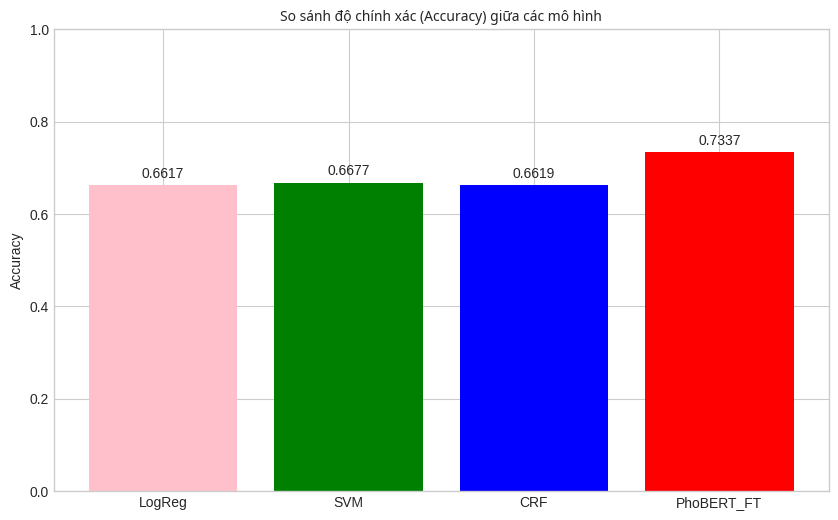

In [20]:
# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 6))
names = list(results.keys())
values = list(results.values())
bars = plt.bar(names, values, color=['pink', 'green', 'blue', 'red'])

title_font = font_prop if font_prop else None
plt.title("So sánh độ chính xác (Accuracy) giữa các mô hình", fontproperties=title_font)
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

plt.show()

Đang xử lý Logistic Regression...
Đang xử lý SVM...
Đang xử lý CRF...
Đang xử lý PhoBERT...


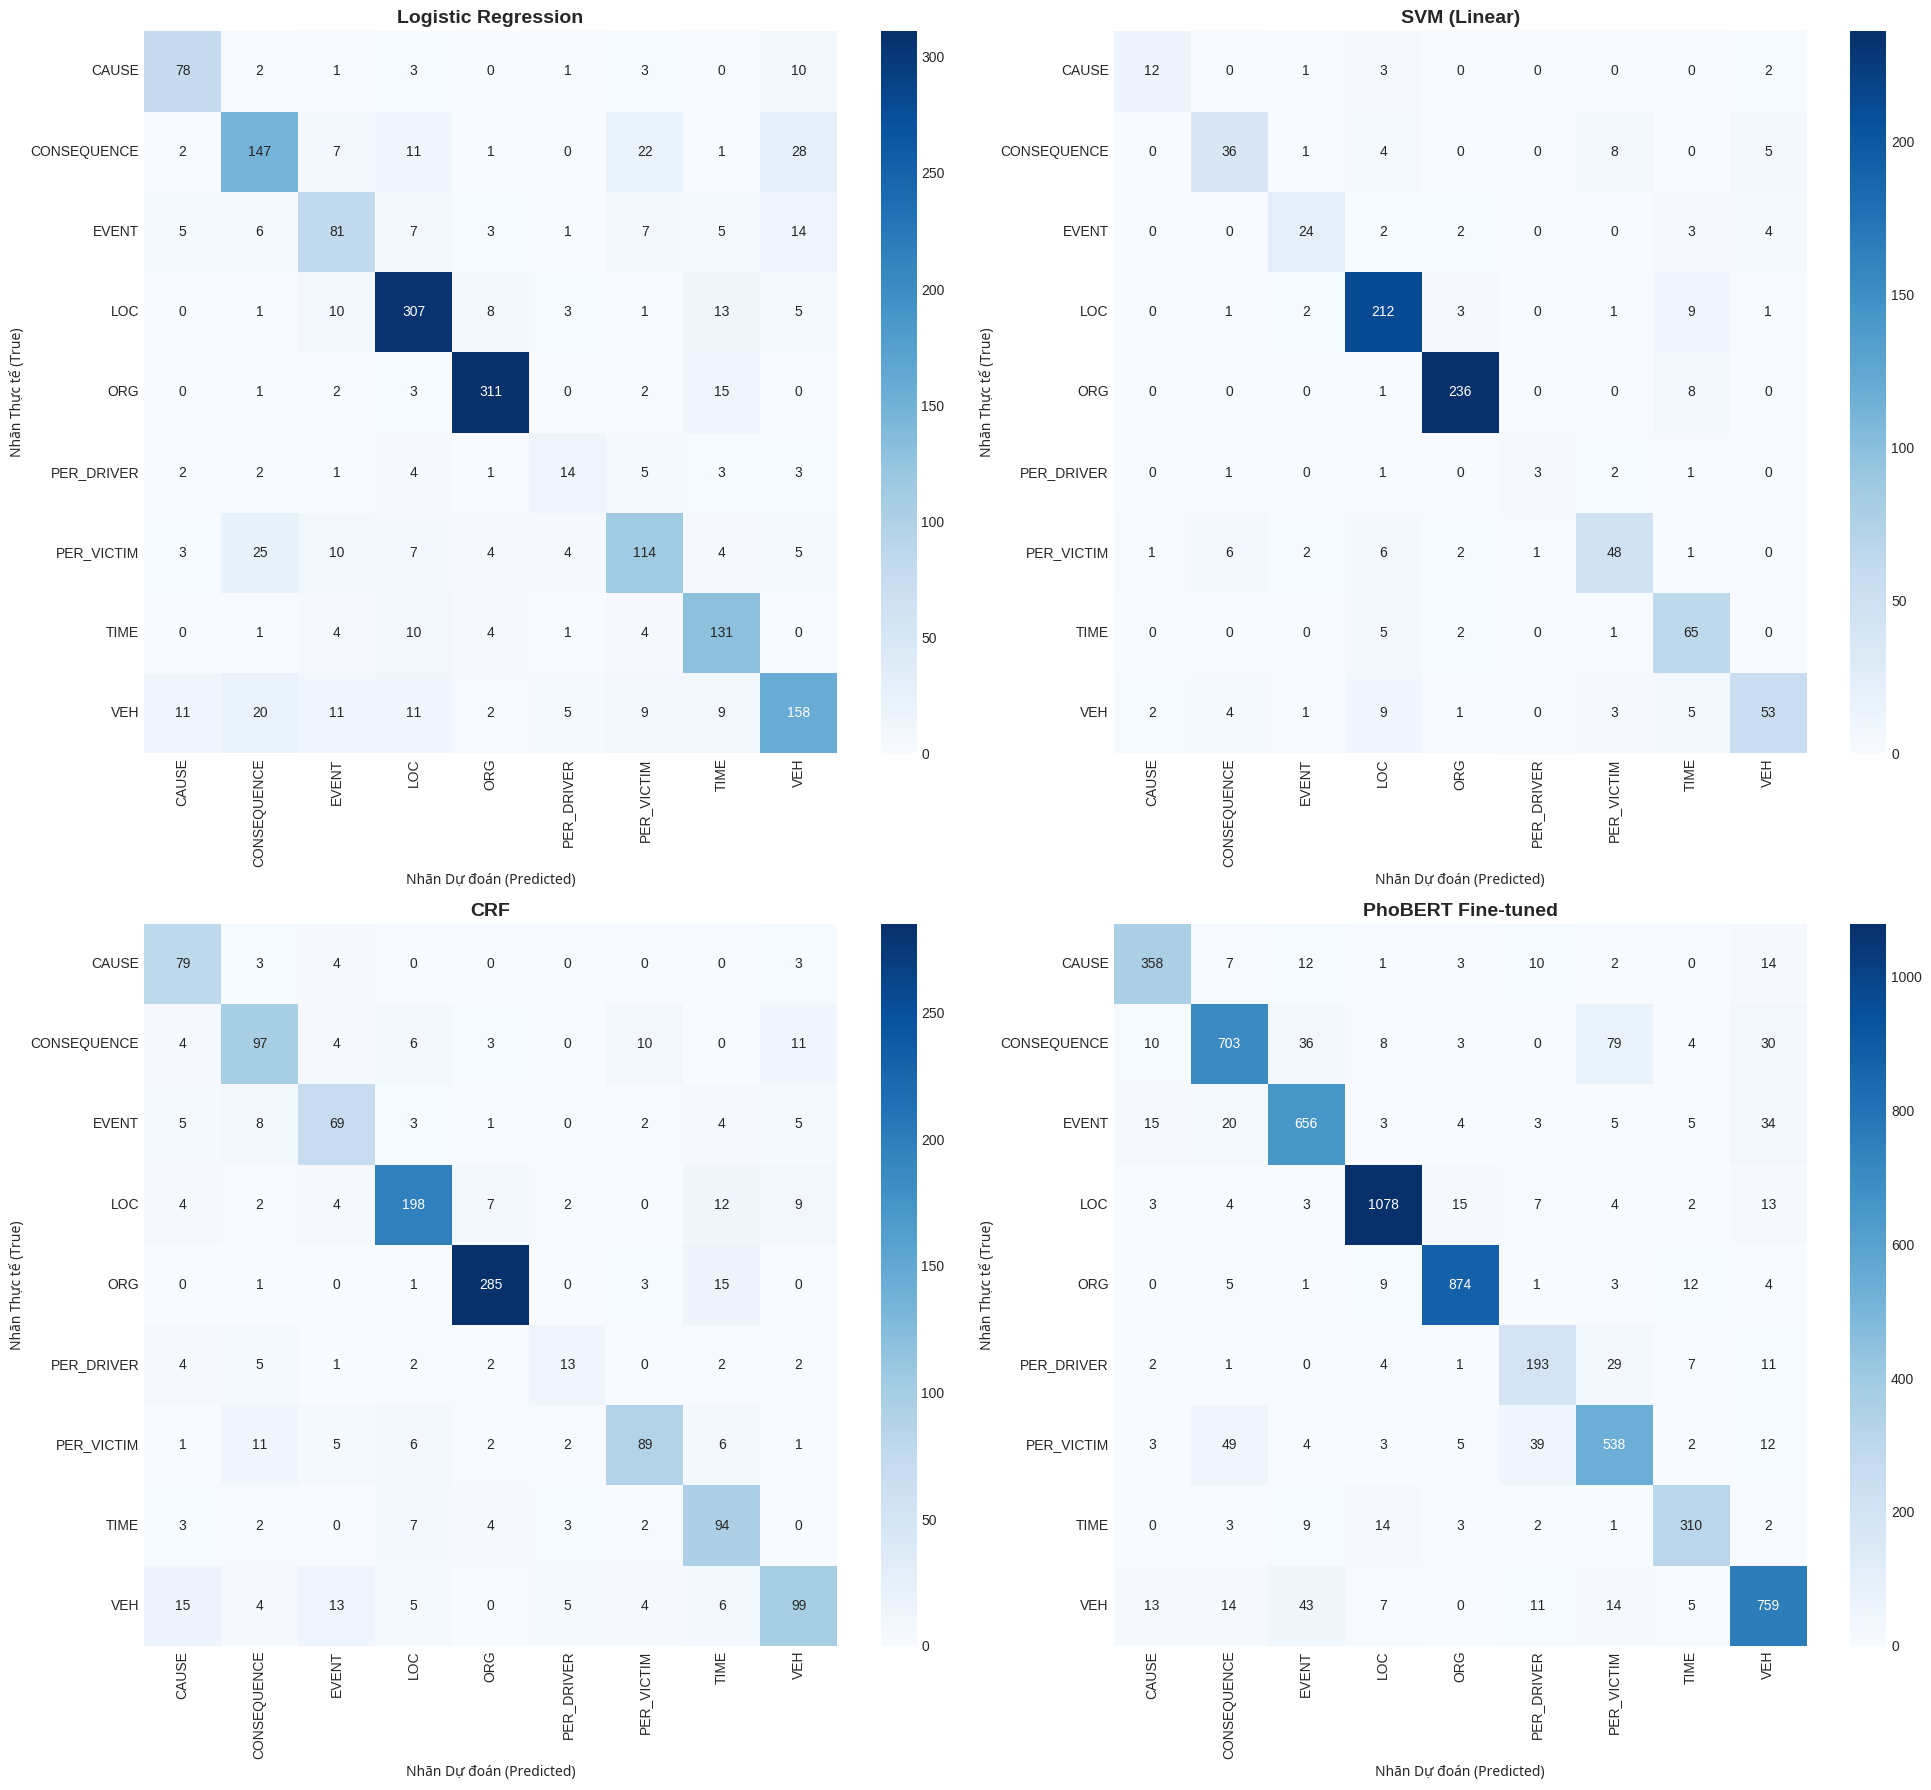

In [21]:
# Chuẩn hóa nhãn (Gộp B-LOC, I-LOC -> LOC)
def clean_labels_for_cm(label_list_raw):
    """
    Chuyển đổi danh sách nhãn:
    - B-LOC -> LOC
    - I-LOC -> LOC
    - O -> O (hoặc bỏ qua nếu muốn)
    """
    clean_list = []
    for label in label_list_raw:
        # Nếu là ID số thì convert sang string trước
        if isinstance(label, (int, np.integer)):
            label = id2label[label]
            
        if label == 'O':
            clean_list.append('O')
        elif '-' in label:
            # Lấy phần sau dấu gạch ngang (VD: B-LOC -> LOC)
            clean_list.append(label.split('-')[1])
        else:
            clean_list.append(label)
    return clean_list

# Vẽ Confusion Matrix
def plot_merged_confusion_matrix(y_true_flat, y_pred_flat, title, ax=None):
    y_true_clean = clean_labels_for_cm(y_true_flat)
    y_pred_clean = clean_labels_for_cm(y_pred_flat)
    
    # Lấy danh sách các nhãn duy nhất (loại trừ 'O' để biểu đồ tập trung vào thực thể)
    unique_labels = sorted(list(set(y_true_clean + y_pred_clean)))
    if 'O' in unique_labels: unique_labels.remove('O')
    
    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true_clean, y_pred_clean, labels=unique_labels)
    
    # Chuẩn hóa (Normalize) để xem phần trăm
    # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Vẽ Heatmap
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels, ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Nhãn Thực tế (True)', fontproperties=title_font)
    ax.set_xlabel('Nhãn Dự đoán (Predicted)', fontproperties=title_font)

# CHUẨN BỊ DỮ LIỆU CỦA 4 MODEL
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

# 1. LOGISTIC REGRESSION
# y_test_ml và y_pred_log đang là ID số -> Hàm sẽ tự convert sang string
print("Đang xử lý Logistic Regression...")
plot_merged_confusion_matrix(y_test_ml, y_pred_log, "Logistic Regression", ax=axes[0, 0])

# 2. SVM
print("Đang xử lý SVM...")
plot_merged_confusion_matrix(y_test_ml, y_pred_svm, "SVM (Linear)", ax=axes[0, 1])

# 3. CRF
# CRF output là list of lists -> Cần flatten (làm phẳng)
print("Đang xử lý CRF...")
flat_true_crf = [l for sent in y_test_crf for l in sent]
flat_pred_crf = [l for sent in y_pred_crf for l in sent]
plot_merged_confusion_matrix(flat_true_crf, flat_pred_crf, "CRF", ax=axes[1, 0])

# 4. PhoBERT
print("Đang xử lý PhoBERT...")
pred_output = trainer.predict(tokenized_test)
pred_ids = np.argmax(pred_output.predictions, axis=2)
label_ids = pred_output.label_ids

# Flatten và loại bỏ các token đặc biệt (-100)
flat_true_bert = []
flat_pred_bert = []

for i in range(len(label_ids)):
    for j in range(len(label_ids[i])):
        if label_ids[i][j] != -100:
            flat_true_bert.append(id2label[label_ids[i][j]])
            flat_pred_bert.append(id2label[pred_ids[i][j]])

plot_merged_confusion_matrix(flat_true_bert, flat_pred_bert, "PhoBERT Fine-tuned", ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Lưu Model

In [22]:
OUTPUT_DIR = "vn_traffic_ner_models"
PHOBERT_SUB_DIR = "phobert_finetuned"

# 1. Tạo thư mục chứa
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)
print(f"Đã tạo thư mục: {OUTPUT_DIR}")

print("="*30)
print("BẮT ĐẦU QUÁ TRÌNH LƯU MODEL")

# LƯU CÁC MODEL MACHINE LEARNING & LABEL LIST
print("\n1. Đang lưu Logistic Regression...")
# Tên biến trong code train là 'log_reg'
joblib.dump(log_reg, os.path.join(OUTPUT_DIR, 'logistic_regression.pkl'))

print("\n2. Đang lưu SVM...")
joblib.dump(svm, os.path.join(OUTPUT_DIR, 'svm_model.pkl'))

print("\n3. Đang lưu CRF...")
# Tên biến trong code train là 'crf'
joblib.dump(crf, os.path.join(OUTPUT_DIR, 'crf_model.pkl'))

print("\n4. Đang lưu Label List...")
label_info = {
    "label_list": label_list,
    "label2id": label2id,
    "id2label": id2label
}
with open(os.path.join(OUTPUT_DIR, 'label_map.json'), 'w', encoding='utf-8') as f:
    json.dump(label_info, f, ensure_ascii=False, indent=4)

print("\n-> Đã lưu xong các model ML truyền thống và bộ mã hóa nhãn.")

# LƯU MODEL DEEP LEARNING (PHOBERT)
print("\n5. Đang lưu PhoBERT Fine-tuned...")
save_path_phobert = os.path.join(OUTPUT_DIR, PHOBERT_SUB_DIR)

# Lưu model và tokenizer
trainer.save_model(save_path_phobert)
tokenizer.save_pretrained(save_path_phobert)

print(f"-> Đã lưu PhoBERT tại: {save_path_phobert}")

Đã tạo thư mục: vn_traffic_ner_models
BẮT ĐẦU QUÁ TRÌNH LƯU MODEL

1. Đang lưu Logistic Regression...

2. Đang lưu SVM...

3. Đang lưu CRF...

4. Đang lưu Label List...

-> Đã lưu xong các model ML truyền thống và bộ mã hóa nhãn.

5. Đang lưu PhoBERT Fine-tuned...
-> Đã lưu PhoBERT tại: vn_traffic_ner_models/phobert_finetuned


In [23]:
# NÉN FILE ĐỂ TẢI VỀ
print("\n6. Đang nén toàn bộ thành file ZIP...")
shutil.make_archive(OUTPUT_DIR, 'zip', OUTPUT_DIR)

print("="*30)
print(f"HOÀN TẤT! File của bạn tên là: {OUTPUT_DIR}.zip")
print(f"Kích thước file: {os.path.getsize(OUTPUT_DIR + '.zip') / (1024*1024):.2f} MB")


6. Đang nén toàn bộ thành file ZIP...
HOÀN TẤT! File của bạn tên là: vn_traffic_ner_models.zip
Kích thước file: 430.76 MB


# Demo

In [ ]:
# import os
# import joblib
# import json
# import numpy as np
# import torch
# from transformers import AutoTokenizer, AutoModel, pipeline

# # --- CẤU HÌNH ---
# MODEL_DIR = "/kaggle/input/vn-traffic-ner-models"
# PHOBERT_NAME = "/kaggle/input/vn-traffic-ner-models/phobert_finetuned"

# # --- 1. HÀM TRÍCH XUẤT ĐẶC TRƯNG (CẬP NHẬT: LOGIC GIỐNG HỆT LÚC TRAIN) ---
# def extract_phobert_features(text, tokenizer, base_model, device):
#     # 1. Tách từ sơ bộ (Split by space)
#     words = text.split() 
    
#     # 2. Đưa vào PhoBERT
#     inputs = tokenizer(words, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
    
#     with torch.no_grad():
#         outputs = base_model(**inputs)
    
#     embeddings = outputs.last_hidden_state[0].cpu().numpy()
    
#     # 3. XỬ LÝ WORD_IDS (LOGIC Y CHANG LÚC TRAIN)
#     try:
#         word_ids = inputs.word_ids()
#     except ValueError:
#         # Fallback thủ công: Tokenize từng từ để tái tạo word_ids
#         word_ids = [None] # Bắt đầu bằng [CLS] (None)
        
#         for i, word in enumerate(words):
#             # Tokenize riêng từng từ để biết nó tách ra bao nhiêu subword
#             sub_tokens = tokenizer.encode(word, add_special_tokens=False)
#             # Gán index từ gốc cho tất cả subword của nó
#             word_ids.extend([i] * len(sub_tokens))
        
#         word_ids.append(None) # Kết thúc bằng [SEP] (None)
        
#         # Xử lý độ dài để khớp với input_ids thực tế
#         input_len = inputs['input_ids'].shape[1]
        
#         if len(word_ids) > input_len:
#             # Nếu dài hơn (do truncate), cắt bớt
#             word_ids = word_ids[:input_len]
#         elif len(word_ids) < input_len:
#             # Nếu ngắn hơn (do padding), điền thêm None
#             word_ids.extend([None] * (input_len - len(word_ids)))

#     # 4. TỔNG HỢP FEATURE
#     features_svm = [] 
#     sent_feats_crf = []
#     valid_words = [] 
    
#     seen_idx = set()
    
#     for idx, word_id in enumerate(word_ids):
#         if word_id is None: continue
        
#         # Chỉ lấy vector của subword đầu tiên đại diện cho từ đó
#         if word_id not in seen_idx:
#             # Kiểm tra index an toàn (tránh lỗi out of bound hiếm gặp)
#             if idx < len(embeddings):
#                 vec = embeddings[idx]
                
#                 # Feature cho SVM/LogReg
#                 features_svm.append(vec)
                
#                 # Feature cho CRF
#                 feat_dict = {f'd{i}': v for i, v in enumerate(vec)}
#                 sent_feats_crf.append(feat_dict)
                
#                 valid_words.append(words[word_id])
#                 seen_idx.add(word_id)
            
#     return valid_words, np.array(features_svm), [sent_feats_crf]

# # --- GỘP TOKEN THÀNH THỰC THỂ (CHUNKING) ---
# def aggregate_entities(tokens, labels):
#     """
#     Input: 
#       tokens = ['ngã', 'tư', 'Thủ', 'Đức', ',', 'xe']
#       labels = ['B-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'B-VEH']
#     Output:
#       [{'word': 'ngã tư Thủ Đức', 'entity': 'LOC'}, {'word': 'xe', 'entity': 'VEH'}]
#     """
#     entities = []
#     current_entity = None
    
#     for token, label in zip(tokens, labels):
#         if label == 'O':
#             if current_entity: # Nếu đang có thực thể dở dang thì lưu lại
#                 entities.append(current_entity)
#                 current_entity = None
#             continue
            
#         # Tách B-LOC thành prefix=B, type=LOC
#         prefix = label[0]
#         entity_type = label[2:]
        
#         if prefix == 'B':
#             if current_entity: # Lưu cái cũ trước khi bắt đầu cái mới
#                 entities.append(current_entity)
#             current_entity = {'word': token, 'entity': entity_type}
            
#         elif prefix == 'I':
#             if current_entity and current_entity['entity'] == entity_type:
#                 # Ghép từ vào (thêm khoảng trắng cho đẹp)
#                 # Lưu ý: Tiếng Việt ghép từ cần khoảng trắng, trừ dấu câu
#                 if token in [',', '.', '!', '?']:
#                     current_entity['word'] += token
#                 else:
#                     current_entity['word'] += " " + token
#             else:
#                 # Trường hợp lỗi: Gặp I mà không có B (hoặc khác loại), coi như B mới
#                 if current_entity:
#                     entities.append(current_entity)
#                 current_entity = {'word': token, 'entity': entity_type}

#     # Lưu cái cuối cùng nếu còn
#     if current_entity:
#         entities.append(current_entity)
        
#     return entities

# # --- HÀM DEMO ---
# def run_demo_final(input_text):
#     print(f"CÂU GỐC: \"{input_text}\"")
#     print("="*60)
    
#     # Load Label Map
#     try:
#         with open(os.path.join(MODEL_DIR, 'label_map.json'), 'r', encoding='utf-8') as f:
#             label_map = json.load(f)
#         id2label = {int(k): v for k, v in label_map['id2label'].items()}
#     except:
#         label_list = ["O", "B-LOC", "I-LOC", "B-VEH", "I-VEH", "B-EVENT", "I-EVENT", "B-PER_DRIVER", "I-PER_DRIVER", "B-PER_VICTIM", "I-PER_VICTIM", "B-ORG", "I-ORG", "B-CONSEQUENCE", "I-CONSEQUENCE", "B-TIME", "I-TIME", "B-CAUSE", "I-CAUSE"]
#         id2label = {i: l for i, l in enumerate(label_list)}

#     print("Đang nạp PhoBERT & xử lý đặc trưng...")
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     try: tokenizer_base = AutoTokenizer.from_pretrained(PHOBERT_NAME, use_fast=True)
#     except: tokenizer_base = AutoTokenizer.from_pretrained(PHOBERT_NAME, use_fast=False)
#     base_model = AutoModel.from_pretrained(PHOBERT_NAME).to(device)
    
#     # TRÍCH XUẤT
#     tokens, X_svm, X_crf = extract_phobert_features(input_text, tokenizer_base, base_model, device)
    
#     # --- MODEL 1: SVM ---
#     try:
#         svm = joblib.load(os.path.join(MODEL_DIR, 'svm_model.pkl'))
#         y_pred = svm.predict(X_svm)
#         if isinstance(y_pred[0], (int, np.integer)): y_pred = [id2label[i] for i in y_pred]
        
#         # GỘP NHÃN
#         entities = aggregate_entities(tokens, y_pred)
#         print(f"\n1. KẾT QUẢ SVM:\n{'-'*40}")
#         for e in entities: print(f"{e['word']:<30} | {e['entity']}")
#     except Exception as e: print(f"Lỗi SVM: {e}")

#     # --- MODEL 2: LOG REG ---
#     try:
#         log_reg = joblib.load(os.path.join(MODEL_DIR, 'logistic_regression.pkl'))
#         y_pred = log_reg.predict(X_svm)
#         if isinstance(y_pred[0], (int, np.integer)): y_pred = [id2label[i] for i in y_pred]
        
#         entities = aggregate_entities(tokens, y_pred)
#         print(f"\n2. KẾT QUẢ LOG REG:\n{'-'*40}")
#         for e in entities: print(f"{e['word']:<30} | {e['entity']}")
#     except Exception as e: print(f"Lỗi LogReg: {e}")

#     # --- MODEL 3: CRF ---
#     try:
#         crf = joblib.load(os.path.join(MODEL_DIR, 'crf_model.pkl'))
#         y_pred = crf.predict(X_crf)[0]
        
#         entities = aggregate_entities(tokens, y_pred)
#         print(f"\n3. KẾT QUẢ CRF:\n{'-'*40}")
#         for e in entities: print(f"{e['word']:<30} | {e['entity']}")
#     except Exception as e: print(f"Lỗi CRF: {e}")

#     # --- MODEL 4: PHOBERT ---
#     try:
#         print("\n" + "="*60)
#         phobert_path = os.path.join(MODEL_DIR, "phobert_finetuned")
#         nlp = pipeline("token-classification", model=phobert_path, tokenizer=phobert_path, aggregation_strategy="simple")
#         results = nlp(input_text)
        
#         print(f"4. KẾT QUẢ PHOBERT (FINE-TUNED):\n{'-'*40}")
#         for entity in results:
#             print(f"{entity['word']:<30} | {entity['entity_group']}")
#     except Exception as e: print(f"Lỗi PhoBERT: {e}")

# # --- CHẠY THỬ ---
# text = "Vào khoảng 15h30 ngày 15/12 , tại ngã tư Thủ Đức , xe máy va chạm với container khiến ông Nguyễn Văn A tử vong ."
# run_demo_final(text)